In [1]:
import os
import sys
# os.chdir("..")
sys.path.append(os.path.abspath(".."))

import torch
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
import torchaudio
import glob

from model.VRNN import VRNN
from dataset.audio_dataset import AudioDataset
from utils.padding import collate_fn
from experiments.train import train, evaluate

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = VRNN().to(device)

/home/deodato/.pyenv/versions/3.10.6/envs/dafi/lib/python3.10/site-packages/torch/cuda/__init__.py:182: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:119.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
data_dir = "../data/mels_saved"
dataset = AudioDataset(data_dir)

N = len(dataset)
train_len = int(0.8 * N)
val_len = int(0.1 * N)
test_len = N - train_len - val_len

In [4]:
g = torch.Generator().manual_seed(42)

train_dataset, val_dataset, test_dataset = random_split(
    dataset,
    [train_len, val_len, test_len],
    generator=g
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [5]:
# Récupère le premier batch
batch = next(iter(train_loader))
print("Type du batch:", type(batch))
print("Shape du batch:", batch.shape)

x0 = batch[:, 0, :]   # shape = (seq_len, mel_dim)
print("Shape séquence 0 :", x0.shape)
print(x0)

Type du batch: <class 'torch.Tensor'>
Shape du batch: torch.Size([200, 32, 80])
Shape séquence 0 : torch.Size([200, 80])
tensor([[-1.3839, -0.9573, -0.6578,  ..., -0.4090, -0.4636, -0.4664],
        [-0.7970, -0.4562, -0.1665,  ..., -0.5144, -0.4339, -0.5126],
        [-0.3304, -0.5458, -0.1980,  ..., -0.5943, -0.4878, -0.5509],
        ...,
        [ 0.5261,  0.1938, -0.0827,  ..., -1.0107, -1.0145, -1.0358],
        [ 0.9114,  0.9400,  0.1695,  ..., -1.0110, -0.9421, -0.8928],
        [ 0.4617, -0.0416,  0.1531,  ..., -0.9517, -0.8963, -0.7447]])


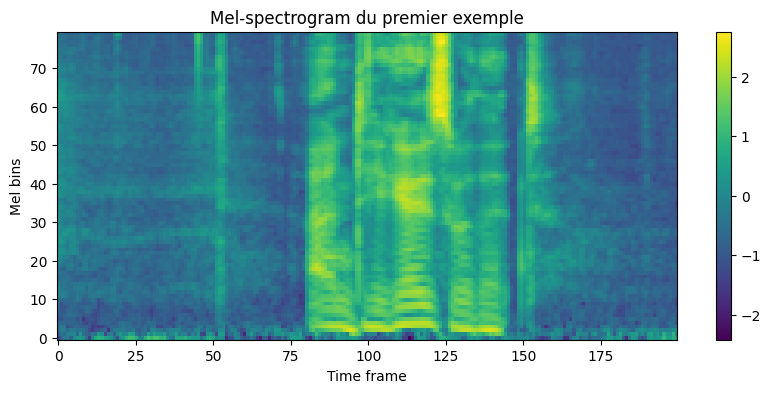

In [10]:
plt.figure(figsize=(10,4))
plt.imshow(x0.T, aspect="auto", origin="lower")
plt.colorbar()
plt.title("Mel-spectrogram du premier exemple")
plt.xlabel("Time frame")
plt.ylabel("Mel bins")
plt.show()

In [ ]:
history = train(model=model, train_loader=train_loader, val_loader=val_loader, 
                epochs=250, lr=2e-3, patience=50,
                batch_size=32, device=device)

[1/50] Train: 34.129 | Val: 28.723 | β=0.000
 → Saved BEST model
[2/50] Train: 14.247 | Val: -1.352 | β=0.100
 → Saved BEST model
[3/50] Train: -9.733 | Val: -13.568 | β=0.200
 → Saved BEST model
[4/50] Train: -16.154 | Val: -16.558 | β=0.300
 → Saved BEST model
[5/50] Train: -18.099 | Val: -18.013 | β=0.400
 → Saved BEST model
[6/50] Train: -18.918 | Val: -18.774 | β=0.500
 → Saved BEST model
[7/50] Train: -19.694 | Val: -19.242 | β=0.600
 → Saved BEST model
[8/50] Train: -19.909 | Val: -19.852 | β=0.700
 → Saved BEST model
[9/50] Train: -20.841 | Val: -20.392 | β=0.800
 → Saved BEST model
[10/50] Train: -21.308 | Val: -20.996 | β=0.900
 → Saved BEST model
[11/50] Train: -21.606 | Val: -20.966 | β=1.000
[12/50] Train: -21.888 | Val: -21.249 | β=1.000
 → Saved BEST model
[13/50] Train: -22.314 | Val: -21.642 | β=1.000
 → Saved BEST model
[14/50] Train: -22.590 | Val: -22.057 | β=1.000
 → Saved BEST model
[15/50] Train: -22.575 | Val: -22.007 | β=1.000
[16/50] Train: -22.698 | Val: -22.

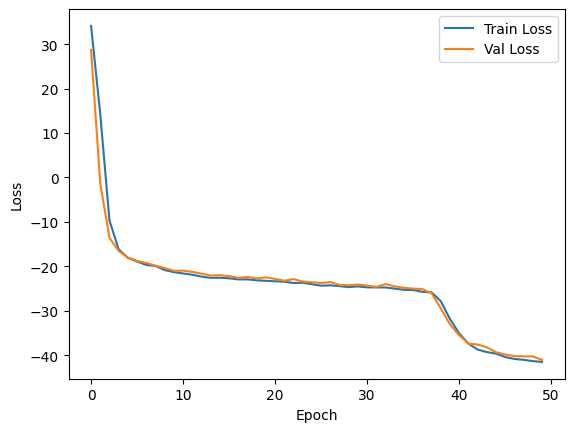

In [8]:
plt.plot(history['train'], label="Train Loss")
plt.plot(history['val'], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [11]:
checkpoint = torch.load("checkpoints/best.pt", map_location=device)
model.load_state_dict(checkpoint["model_state"])

<All keys matched successfully>

In [12]:
test_recon, test_kld = evaluate(model, test_loader, device)

In [13]:
test_recon

-46.52146530151367

In [14]:
test_kld

5.522536754608154